In [46]:
import numpy as np
import matplotlib.pyplot as plt
import os
import xarray as xr
import xgcm 
from fastjmd95 import jmd95numba 

BASE = '/scratch/ab10313/pleiades/'

#path
PATH_PP = '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/'

# paths to dataset
PATH_2d = '/scratch/ab10313/pleiades/01_gulf_smooth/2d_data/'
PATH_3d = '/scratch/ab10313/pleiades/01_gulf_smooth/3d_data/'

# make diirectory for preprocessed variables
PATH_PP = '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/'
#os.mkdir(PATH_PP)



# load 2d data
ds_HBL = xr.open_dataset(PATH_2d+'ds_HBL.nc',engine="h5netcdf")
ds_Q = xr.open_dataset(PATH_2d+'ds_Q.nc',engine="h5netcdf")
ds_TAUX = xr.open_dataset(PATH_2d+'ds_TAUX.nc',engine="h5netcdf")
ds_TAUY = xr.open_dataset(PATH_2d+'ds_TAUY.nc',engine="h5netcdf")


# load 3d data
ds_T = xr.open_dataset(PATH_3d+'ds_T.nc',engine="h5netcdf")
ds_S = xr.open_dataset(PATH_3d+'ds_S.nc',engine="h5netcdf")
ds_U = xr.open_dataset(PATH_3d+'ds_U.nc',engine="h5netcdf")
ds_V = xr.open_dataset(PATH_3d+'ds_V.nc',engine="h5netcdf")
ds_W = xr.open_dataset(PATH_3d+'ds_W.nc',engine="h5netcdf")



# find min and max i and j to crop to 10X10 degrees

i_min = np.max([ds_HBL.i.min().values,ds_Q.i.min().values, ds_TAUX.i_g.min().values, ds_TAUY.i.min().values,
                ds_T.i.min().values, ds_S.i.min().values, ds_U.i_g.min().values, ds_V.i.min().values, ds_W.i.min().values])


i_max = np.min([ds_HBL.i.max().values,ds_Q.i.max().values, ds_TAUX.i_g.max().values, ds_TAUY.i.max().values,
                ds_T.i.max().values, ds_S.i.max().values, ds_U.i_g.max().values, ds_V.i.max().values, ds_W.i.max().values])


j_min = np.max([ds_HBL.j.min().values,ds_Q.j.min().values, ds_TAUX.j.min().values, ds_TAUY.j_g.min().values,
                ds_T.j.min().values, ds_S.j.min().values, ds_U.j.min().values, ds_V.j_g.min().values, ds_W.j.min().values])


j_max = np.min([ds_HBL.j.max().values,ds_Q.j.max().values, ds_TAUX.j.max().values, ds_TAUY.j_g.max().values,
                ds_T.j.max().values, ds_S.j.max().values, ds_U.j.max().values, ds_V.j_g.max().values, ds_W.j.max().values])



#define slice to 480 index

if i_min+480>i_max:
    print('cropped region error in i')
elif j_min+480>j_max:
    print('cropped region error in j')
else:
    i_slice = slice(i_min,i_min+480)
    j_slice = slice(j_min,j_min+480)




# merge datasets
ds_2d =xr.merge([ds_HBL.sel(i=i_slice,j=j_slice), ds_Q.sel(i=i_slice,j=j_slice),
                 ds_TAUX.sel(i_g=i_slice,j=j_slice), ds_TAUY.sel(i=i_slice,j_g=j_slice)]).isel(time=332)#.isel(time=700)#


ds_3d =xr.merge([ds_T.sel(i=i_slice,j=j_slice), ds_S.sel(i=i_slice,j=j_slice),
                 ds_U.sel(i_g=i_slice,j=j_slice), ds_V.sel(i=i_slice,j_g=j_slice), ds_W.sel(i=i_slice,j=j_slice)]).isel(time=332)#.isel(time=700)##




In [47]:
ds = np.sqrt((ds_2d.dxF.mean())**2 + (ds_2d.dyF.mean())**2).values
ds*12

31354.9423828125

In [48]:

# define grids 

grid_2d = xgcm.Grid(ds_2d)

grid_3d = xgcm.Grid(ds_3d)


# sigma from temp and salt, using the fastjmd95 package

    
# reference density 
rho0 = 1000 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0 = jmd95numba.rho(ds_3d.Salt.chunk(chunks={'j': ds_3d.j.size, 'i': ds_3d.i.size}),
                         ds_3d.Theta.chunk(chunks={'j': ds_3d.j.size, 'i': ds_3d.i.size}), 0) - rho0

sigma0 = sigma0.rename('sigma0')

# sigma0 at 10m depth for reference

sigma0_10m = sigma0.isel(k=6).broadcast_like(sigma0).chunk(chunks={ 'j': ds_3d.j.size, 'i': ds_3d.i.size})
delta_sigma = sigma0 - sigma0_10m
del sigma0_10m


# gravity
G = 9.81 #m/s^2

# buoyancy
B = -G*sigma0/rho0
B = B.rename('Buoyancy')


# vertical buoyancy gradient (stratification) note the minus sign because z is negative
Nsquared = -B.diff(dim='k')/B.drF
Nsquared_plot = Nsquared.where(delta_sigma<=0.03).mean(dim="k",skipna=True)

# horizontal x buoyancy gradient
B_x = B.diff(dim='i')/B.dxF
B_x_MLD = B_x.where(delta_sigma<=0.03).mean(dim="k",skipna=True)

# horizontal y buoyancy gradient
B_y = B.diff(dim='j')/B.dyF
B_y_MLD = B_y.where(delta_sigma<=0.03).mean(dim="k",skipna=True)

grad_B_plot = np.sqrt(B_x_MLD**2 + B_y_MLD**2)


# mixed layer depth
HML = sigma0.Z.broadcast_like(sigma0).where(delta_sigma<=0.03).min(dim="k",skipna=True).chunk(chunks={'j': sigma0.j.size, 'i': sigma0.i.size}).rename('Mixed Layer Depth')
HML_plot = HML


# interp velocities and buoyancy fluxes, average over MLD
W_interp = grid_3d.interp(ds_3d.W,'Z', boundary='extend')
WB = W_interp * B
WB_plot = WB.where(delta_sigma<=0.03).mean(dim="k",skipna=True)

WB_plot_sg = WB_plot-W_interp.where(delta_sigma<=0.03).mean(dim="k",skipna=True)*B.where(delta_sigma<=0.03).mean(dim="k",skipna=True)

# interp tau

TAUX_interp = grid_2d.interp(ds_2d.oceTAUX,'X', boundary='extend')
TAUY_interp = grid_2d.interp(ds_2d.oceTAUY,'Y', boundary='extend')

TAU_plot = np.sqrt(TAUY_interp**2 + TAUX_interp**2)

# save HBL

HBL_plot = ds_2d.KPPhbl


# save Q
Q_plot = ds_2d.oceQnet


# lat lon
lat = ds_2d.YC.mean('i')
lon = ds_2d.XC.mean('j')

#lat.to_netcdf(PATH_PP+'lat.nc',engine='h5netcdf')
#lon.to_netcdf(PATH_PP+'lon.nc',engine='h5netcdf')

# Coriolis 
omega = 7.2921e-5

FCOR = xr.zeros_like(B.isel(k=0))

for ii in range(len(lat)):
        FCOR[ii,:] = 2*omega*np.sin(lat[ii]* np.pi / 180.)

FCOR_plot = FCOR




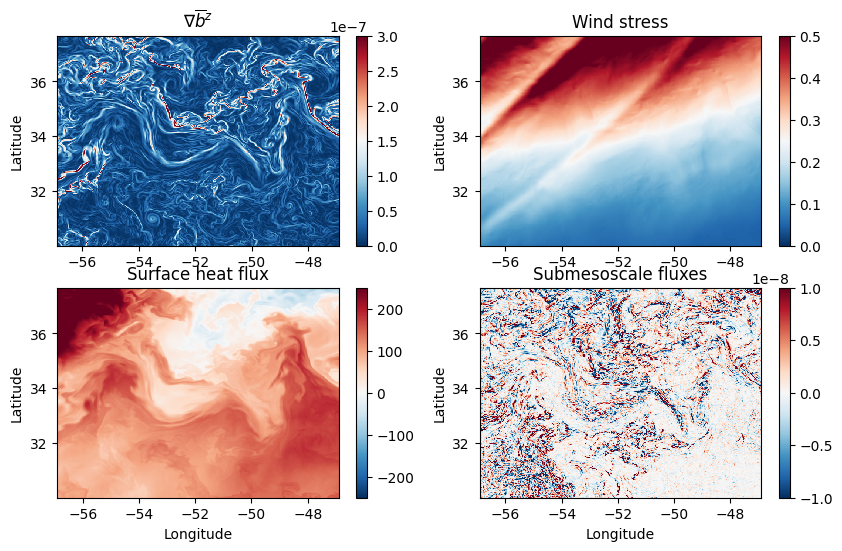

In [49]:
fig, axes =plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

    
plt.subplot(221)


plt.subplot(221)
plt.pcolor(lon.values,lat.values,grad_B_plot.values, cmap='RdBu_r',vmin=0,vmax=3e-7)
#plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title(r'$\nabla \overline{ b}^z$')


plt.subplot(222)
plt.pcolor(lon.values,lat.values,TAU_plot.values, cmap='RdBu_r',vmin=0,vmax=0.5)
#plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('Wind stress')


plt.subplot(223)
plt.pcolor(lon.values,lat.values,Q_plot.values, cmap='RdBu_r',vmin=-250,vmax=250)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('Surface heat flux')

plt.subplot(224)
plt.pcolor(lon.values,lat.values,WB_plot_sg.values,  cmap='RdBu_r',vmin=-1e-8,vmax=1e-8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('Submesoscale fluxes')

plt.savefig('./highres_fields_gulf_JFM.png')

## Visualization of FK parameterization and sensitivity to Lf

In [ ]:
BASE = '/scratch/ab10313/pleiades/'
PATH_PP = '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/'
PATH_NN = BASE+'NN_data_smooth/'

def smooth(data,time_window, coarsen_factor):
    if len(data.dims) == 3:
        smoothed_data = data.rolling(time=time_window, center=True).mean().dropna(dim="time", how="all").coarsen(i=coarsen_factor,j=coarsen_factor, boundary="trim").mean()
    elif len(data.dims) == 2:
        smoothed_data = np.tile(data.coarsen(i=coarsen_factor,j=coarsen_factor, boundary="trim").mean(),(845,1,1))
    return smoothed_data



def FK_param(PATH,time_window=15,coarsen_factor=12):
    # FK08 parameterization inputs
    tau = 86400
    FCOR = smooth(xr.open_dataarray(PATH+'FCOR.nc'),time_window,coarsen_factor)
    
    # coarse-res horizontal buoyancy gradient
    B = smooth(xr.open_dataarray(PATH+'B.nc'),time_window=15,coarsen_factor=12)
    B_x = (B.diff(dim='i')/(12*B.dxF)).interp(i=B.i,j=B.j,kwargs={"fill_value": "extrapolate"}).values
    B_y = (B.diff(dim='j')/(12*B.dyF)).interp(i=B.i,j=B.j,kwargs={"fill_value": "extrapolate"}).values
    grad_B = np.sqrt(B_y**2 + B_x**2)
    
    HML = smooth(xr.open_dataarray(PATH+'HML.nc'),time_window,coarsen_factor).values
    
    WB_FK = ((HML**2) * (grad_B**2))/np.sqrt(FCOR**2)#( (grad_B**2))/np.sqrt(FCOR**2 + tau**-2)#
    
    return WB_FK


def FK_param_Lf(PATH,time_window=15,coarsen_factor=12):
    # FK08 parameterization inputs
    #tau = 86400
    FCOR = smooth(xr.open_dataarray(PATH+'FCOR.nc'),time_window,coarsen_factor)
    
    HML = smooth(xr.open_dataarray(PATH+'HML.nc'),time_window,coarsen_factor).values
    #also making Nsquared very small but not zero to avoid singularity
    Nsquared = smooth(xr.open_dataarray(PATH+'Nsquared.nc'),time_window,coarsen_factor).values
    Nsquared[Nsquared<=1e-6]=1e-6
    
    # WB FK11 with Lf rescaling factor
    ds = 25e3 # approx 1/4 degree resolution  ~ 25km
    Lf = (np.sqrt(Nsquared)*(-HML))/np.sqrt(FCOR**2)
    return Lf 



def Bod_param_Lf(PATH,time_window=15,coarsen_factor=12):
    # Bodner23 parameterization inputs
    FCOR = smooth(xr.open_dataarray(PATH+'FCOR.nc'),time_window,coarsen_factor)

    TAUX = smooth(xr.open_dataarray(PATH+'TAUX.nc'),time_window,coarsen_factor).values
    TAUY = smooth(xr.open_dataarray(PATH+'TAUY.nc'),time_window,coarsen_factor).values
    TAU = np.sqrt(TAUY**2 + TAUX**2)

    Q = smooth(xr.open_dataarray(PATH+'Q.nc'),time_window,coarsen_factor).values
    HBL = smooth(xr.open_dataarray(PATH+'HBL.nc'),time_window,coarsen_factor).values
    
    # WB FK11 with Bod Lf rescaling factor
    ds = 25e3 # approx 1/4 degree resolution  ~ 25km
    m_star = 0.5
    n_star = 0.066
    Cl = 0.25
    rho0 = 1025
    u_star = np.sqrt(np.abs(TAU)/rho0)
    
    # w_star
    cp_w = 4.2e3 
    grav = 9.81 
    gcp = grav/cp_w 
    t00b = 5000 
    bfac = 1 
    batag = bfac*grav/t00b  #multiply temp*batag to get buoyancy
    galpha = 1.962e-3              #conversion from T to b (Ttob)
    w_fac = galpha/rho0/cp_w 
    w_star = (abs(batag*gcp * Q*HBL))**(1/3) 

    Lf = (Cl * (m_star*u_star**3 + n_star*w_star**3)**(2/3))/((FCOR**2)*(HBL))
    return Lf

    


# WB
B = smooth(xr.open_dataarray(PATH_PP+'B.nc'),time_window=15,coarsen_factor=12)
W = smooth(xr.open_dataarray(PATH_PP+'W.nc'),time_window=15,coarsen_factor=12)
WB = smooth(xr.open_dataarray(PATH_PP+'WB.nc'),time_window=15,coarsen_factor=12)
    
# WB subgrid
WB_sg = WB - W*B
    
#WB_sg = np.load(PATH_NN+'WB_sg.npy')
WB_FK = FK_param(PATH_PP)

In [ ]:
Lf_FK11 = FK_param_Lf(PATH_PP)

In [ ]:
Lf_FK11

In [ ]:
Lf_BD23 = Bod_param_Lf(PATH_PP)

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

Lf = (1+np.arange(WB_sg.shape[0])[::-1])*10

plt.subplot(121)
plt.pcolor(lat.coarsen(j=12, boundary="trim").mean(), lon.coarsen(i=12, boundary="trim").mean(), WB_sg.isel(time=100), cmap='inferno',vmin=-1e-9, vmax=1e-7)
plt.title('WB_sg')
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar()

plt.subplot(122)
plt.pcolor(lat.coarsen(j=12, boundary="trim").mean(), lon.coarsen(i=12, boundary="trim").mean(),(25e3/Lf[100])*0.07*WB_FK[100], cmap='inferno',vmin=-1e-9, vmax=1e-7)
plt.title('WB_FK')
plt.xlabel('lon')
plt.ylabel('lat')
plt.colorbar()

In [ ]:
Lf_down = np.arange(WB_sg.shape[0]*10,10,-100)
Lf_up = np.arange(10,WB_sg.shape[0]*10,100)

Lf_concat = np.concatenate((25e3*np.ones(50),Lf_down,Lf_up,Lf_down,Lf_up))
Lf_concat.shape[0]

In [ ]:
Lf_down = np.arange(WB_sg.shape[0]*10,10,-20)
#Lf_up = np.arange(10,WB_sg.shape[0]*10,100)
Lf_concat = np.concatenate((25e3*np.ones(100),Lf_down))
Lf_concat.shape

In [23]:
# load CNN data 
BASE_gulf = '/scratch/ab10313/pleiades/01_gulf_smooth/'
PATH_NN_gulf = BASE_gulf+'NN_data_smooth/'

X_input_gulf = np.load(PATH_NN_gulf+'X_input_gulf.npy')
Y_output_gulf = np.load(PATH_NN_gulf+'Y_output_gulf.npy')
mean_gulf = np.load(PATH_NN+'WB_sg_mean.npy')
std_gulf = np.load(PATH_NN+'WB_sg_std.npy')

prediction_gulf = np.load(PATH_NN_gulf+'prediction_gulf.npy')

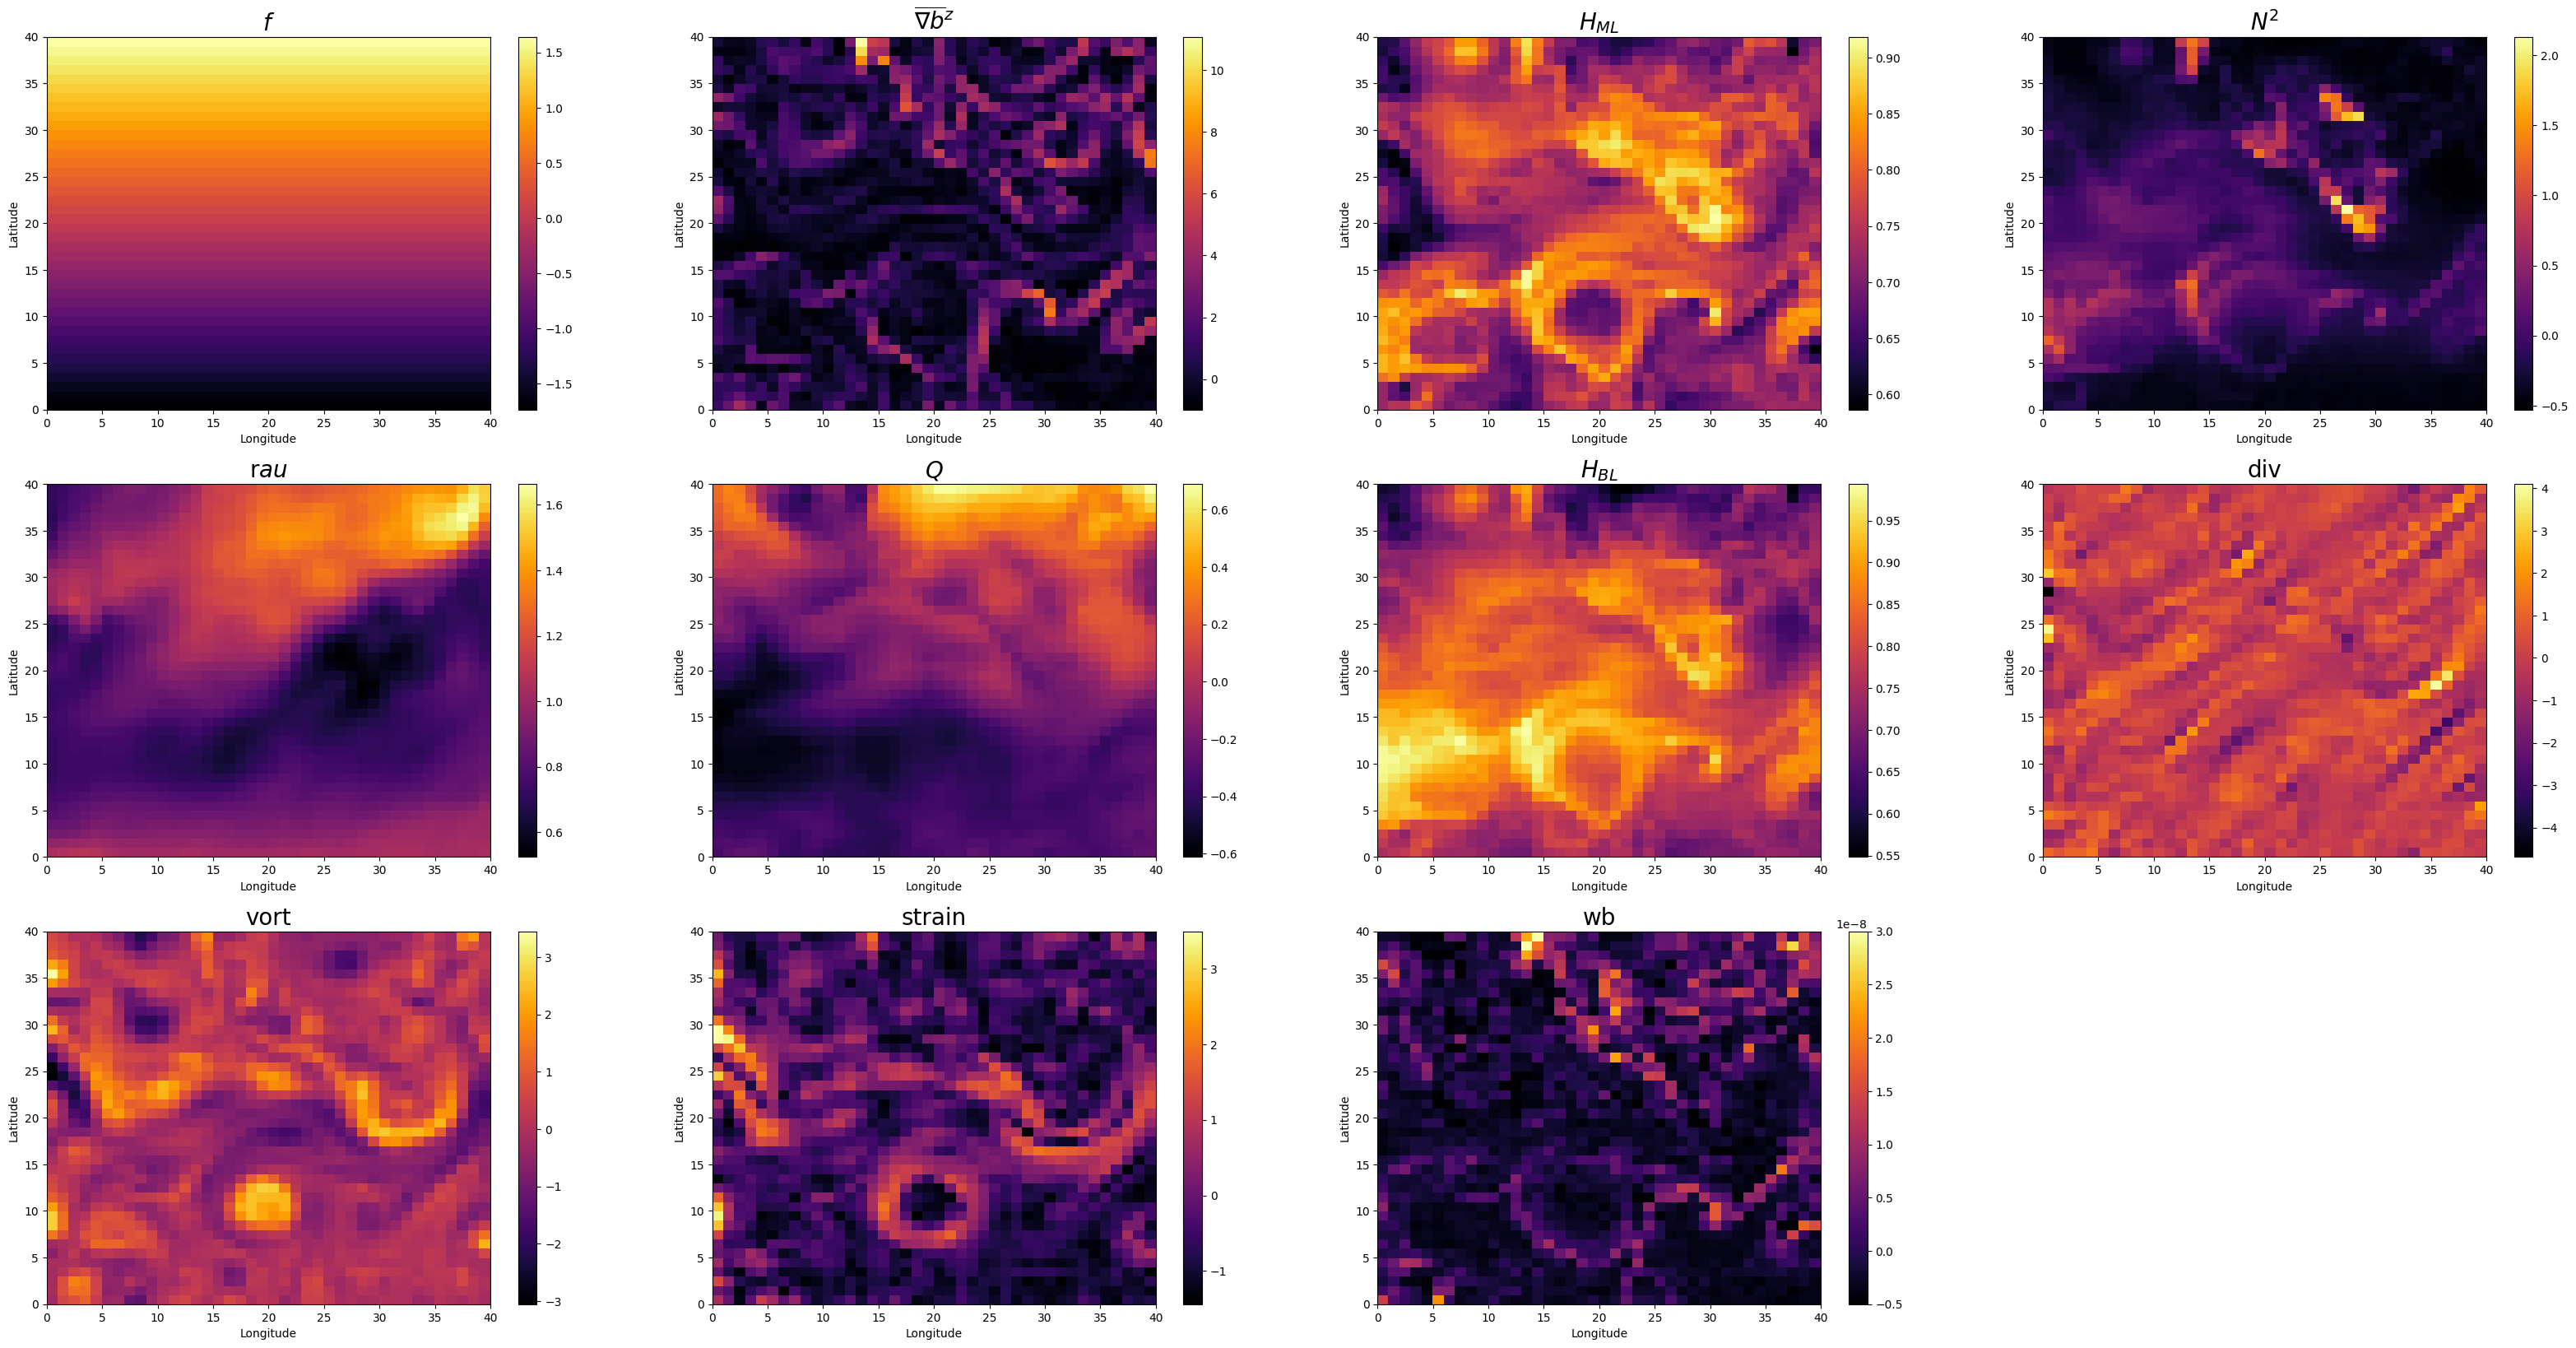

In [67]:
plt.subplots(nrows=3, ncols=4, figsize=(40, 20))

plt.subplot(122)
    
    
plt.subplot(341)
plt.pcolor(X_input_gulf[10,0,:,:], cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('$f$',fontsize=20)

plt.subplot(342)
plt.pcolor(X_input_gulf[10,1,:,:], cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title(r'$\overline{ \nabla b}^z$',fontsize=20)

plt.subplot(343)
plt.pcolor(X_input_gulf[10,2,:,:],  cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title(r'$H_{ML}$',fontsize=20)

plt.subplot(344)
plt.pcolor(X_input_gulf[10,3,:,:], cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('$N^2$',fontsize=20)


plt.subplot(345)
plt.pcolor(X_input_gulf[10,4,:,:], cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('r$\tau$',fontsize=20)

plt.subplot(346)
plt.pcolor(X_input_gulf[10,5,:,:], cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title(r'$Q$',fontsize=20)

plt.subplot(347)
plt.pcolor(-X_input_gulf[10,6,:,:], cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('$H_{BL}$',fontsize=20)

plt.subplot(348)
plt.pcolor(X_input_gulf[10,7,:,:], cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('div',fontsize=20)

plt.subplot(349)
plt.pcolor(X_input_gulf[10,8,:,:], cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('vort',fontsize=20)

plt.subplot(3,4,10)
plt.pcolor(X_input_gulf[10,9,:,:], cmap='inferno')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('strain',fontsize=20)

plt.subplot(3,4,11)
plt.pcolor(Y_output_gulf[10,0,:,:]*std_gulf[10] + mean_gulf[10], cmap='inferno',vmin=-5e-9, vmax=3e-8)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar()
plt.title('wb',fontsize=20)

#[FCOR, grad_B, HML, Nsquared, TAU, Q, HBL, div, vort, strain]

plt.savefig(BASE+'plots/highres_fields_gulf_inferno.png')

In [76]:
from PIL import Image
import os
def create_animation(fun, idx, filename='WB_BD23_FK_RdBu.gif', dpi=None, FPS=24, loop=0):
    '''
    See https://pythonprogramming.altervista.org/png-to-gif/
    fun(i) - a function creating one snapshot, has only one input:
        - number of frame i
    idx - range of frames, i in idx
    FPS - frames per second
    filename - animation name
    dpi - set 300 or so to increase quality
    loop - number of repeats of the gif
    '''
    frames = []
    for i in idx:
        fun(i)
        plt.savefig('.frame.png', dpi=dpi)
        plt.close()
        frames.append(Image.open('.frame.png'))
        print(f'Frame {i} is created', end='\r')
    os.system('rm .frame.png')
    # How long to persist one frame in milliseconds to have a desired FPS
    duration = 1000 / FPS
    print(f'Animation at FPS={FPS} will last for {len(idx)/FPS} seconds')
    frames[0].save(
        filename, format='GIF',
        append_images=frames[1:],
        save_all=True,
        duration=duration,
        loop=loop)

In [19]:
Y_output_gulf.shape

(845, 1, 40, 40)

In [167]:
import pandas as pd 
# visualize compare FK BD CNN

#plt.rcParams['text.usetex'] = True

def fun(j):
    
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 5))
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    plt.subplot(221)
    plt.pcolor(lat.coarsen(j=12, boundary="trim").mean(), lon.coarsen(i=12, boundary="trim").mean(), Y_output_gulf[j,0,:,:]*std_gulf[j] + mean_gulf[j], cmap='RdBu_r',vmin=-1e-8, vmax=1e-8)
    ts = pd.to_datetime(WB_sg.time[j].values) 
    d = ts.strftime('%Y.%m.%d')
    plt.title('$\overline{wb}^z$ LLC4320',fontsize = 12)
    #plt.xlabel('lon')
    plt.ylabel('lat')
    plt.colorbar()

    plt.subplot(222)
    plt.pcolor(lat.coarsen(j=12, boundary="trim").mean(), lon.coarsen(i=12, boundary="trim").mean(),prediction_gulf[j,0,:,:]*std_gulf[j] + mean_gulf[j], cmap='RdBu_r',vmin=-1e-8, vmax=1e-8)
    ts = pd.to_datetime(B.time[j].values) 
    d = ts.strftime('%Y.%m.%d')
    plt.title('$\overline{wb}^z$ CNN prediction',fontsize = 12)
    #plt.xlabel('lon')
    #plt.ylabel('lat')
    plt.colorbar()
    
    plt.subplot(223)
    plt.pcolor(lat.coarsen(j=12, boundary="trim").mean(), lon.coarsen(i=12, boundary="trim").mean(), ((ds*12)/np.maximum(Lf_FK11[j],5000))*0.07*WB_FK[j], cmap='RdBu_r',vmin=-1e-8, vmax=1e-8)
    ts = pd.to_datetime(WB_sg.time[j].values) 
    d = ts.strftime('%Y.%m.%d')
    plt.title('$\overline{wb}^z$ FK11 param',fontsize = 12)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.colorbar()

    plt.subplot(224)
    plt.pcolor(lat.coarsen(j=12, boundary="trim").mean(), lon.coarsen(i=12, boundary="trim").mean(),((ds*12)/Lf_BD23[j])*0.07*WB_FK[j], cmap='RdBu_r',vmin=-1e-8, vmax=1e-8)
    ts = pd.to_datetime(B.time[j].values) 
    d = ts.strftime('%Y.%m.%d')
    plt.title('$\overline{wb}^z$ Bodner23 param',fontsize = 12)
    plt.xlabel('lon')
    #plt.ylabel('lat')
    plt.colorbar()


create_animation(fun, range(500,840))

Animation at FPS=24 will last for 14.166666666666666 seconds


In [75]:
import pandas as pd 
#plt.rcParams['text.usetex'] = True

def fun(j):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    plt.subplot(121)
    plt.pcolor(lat.coarsen(j=12, boundary="trim").mean(), lon.coarsen(i=12, boundary="trim").mean(), WB_sg.isel(time=j), cmap='inferno',vmin=-1e-9, vmax=5e-8)
    ts = pd.to_datetime(WB_sg.time[j].values) 
    d = ts.strftime('%Y.%m.%d')
    plt.title(r'$wb$, time = '+ d)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.colorbar()

    plt.subplot(122)
    plt.pcolor(lat.coarsen(j=12, boundary="trim").mean(), lon.coarsen(i=12, boundary="trim").mean(),(25e3/Lf_BD23[j])*0.07*WB_FK[j], cmap='inferno',vmin=-1e-9, vmax=5e-8)
    ts = pd.to_datetime(B.time[j].values) 
    d = ts.strftime('%Y.%m.%d')
    plt.title(r'$wb$, time = '+ d)
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.colorbar()


create_animation(fun, range(100,250))

Animation at FPS=24 will last for 6.25 seconds


In [162]:
import pandas as pd 
#plt.rcParams['text.usetex'] = True

Lf_down = np.arange(25e3,10,-100)
Lf_up = np.arange(10,25e3,100)
Lf_concat = np.concatenate((Lf_down,Lf_up))

def fun(j):
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
    fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    Lf_down = np.arange(25e3,10,-100)
    Lf_up = np.arange(10,25e3,100)
    Lf_concat = np.concatenate((Lf_down, Lf_up))

    plt.subplot(121)
    plt.pcolor(lat.coarsen(j=12, boundary="trim").mean(), lon.coarsen(i=12, boundary="trim").mean(), WB_sg.isel(time=100), cmap='inferno',vmin=-1e-9, vmax=5e-8)
    ts = pd.to_datetime(WB_sg.time[j].values) 
    d = ts.strftime('%Y.%m.%d')
    #plt.title(r'$wb$, time = '+ d)
    plt.title(r'$wb$')
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.colorbar()

    plt.subplot(122)
    plt.pcolor(lat.coarsen(j=12, boundary="trim").mean(), lon.coarsen(i=12, boundary="trim").mean(),(25e3/Lf_concat[j])*0.07*WB_FK[100], cmap='inferno',vmin=-1e-9, vmax=5e-8)
    ts = pd.to_datetime(B.time[j].values) 
    #d = ts.strftime('%Y.%m.%d')
    plt.title(r'param, Lf (km) = '+ str(np.round(Lf_concat[j]*1e-3)))
    plt.xlabel('lon')
    plt.ylabel('lat')
    plt.colorbar()


create_animation(fun, range(0,len(Lf_concat)))

Animation at FPS=24 will last for 20.833333333333332 seconds


In [159]:
Lf_down = np.arange(25e3,10,-100)
Lf_up = np.arange(10,25e3,100)
Lf_concat = np.concatenate((Lf_down,Lf_up))
len(Lf_concat)

500

# global map


In [1]:
import cartopy 
cartopy.__version__ 

'0.21.1'

In [2]:
import glob
import matplotlib.pyplot as plt
import os
import xarray as xr
import xgcm 
from fastjmd95 import jmd95numba 
import numpy as np


BASE = '/scratch/ab10313/pleiades/'

PATH_LIST_PP = glob.glob(BASE+'*_smooth/preprcossed_data/')


In [3]:
PATH_LIST_PP

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

In [4]:
ds_T_surf = xr.open_dataset(BASE+'global/ds_T_surf.nc',engine='h5netcdf')
ds_S_surf = xr.open_dataset(BASE+'global/ds_S_surf.nc',engine='h5netcdf')

#coarsen resolution to 1/4 degree
ds_surf =xr.merge([ds_T_surf.coarsen(i=12,j=12, boundary="trim").mean(),
                   ds_S_surf.coarsen(i=12,j=12, boundary="trim").mean()])

grid_surf = xgcm.Grid(ds_surf)



In [6]:
# sigma from temp and salt, using the fastjmd95 package

    
# reference density 
rho0 = 1000 #kg/m^3

# potential density anomaly 
# with the reference pressure of 0 dbar and ρ0 = 1000 kg m−3
sigma0_surf = jmd95numba.rho(ds_surf.Salt.chunk(chunks={'j': ds_surf.j.size, 'i': ds_surf.i.size}),
                         ds_surf.Theta.chunk(chunks={'j': ds_surf.j.size, 'i': ds_surf.i.size}), 0) - rho0

sigma0_surf = sigma0_surf.rename('sigma0')


# gravity
G = 9.81 #m/s^2

# buoyancy
B_surf = -G*sigma0_surf/rho0
B_surf = B_surf.rename('Buoyancy')


# horizontal x buoyancy gradient
B_surf_x = B_surf.diff(dim='i')/B_surf.dxF

# horizontal y buoyancy gradient
B_surf_y = B_surf.diff(dim='j')/B_surf.dyF

grad_B_surf_plot = np.sqrt(B_surf_y**2 + B_surf_x**2)

In [32]:
def lonlat_minmax(var_name_string):
    PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/'+var_name_string+'.nc') 
    data_min = np.zeros(len(PATH_LIST))
    data_max = np.zeros(len(PATH_LIST))
    for i_file in np.arange(0,len(PATH_LIST)):
        PATH = PATH_LIST[i_file]
        data = xr.open_dataarray(PATH)
        data_min[i_file] = np.round(data.min().values)
        data_max[i_file] = np.round(data.max().values)   
    return data_min, data_max

In [34]:
lat_min_data, lat_max_data = lonlat_minmax('lat')
lon_min_data, lon_max_data = lonlat_minmax('lon')

In [35]:
lon_min = [-60, -25, -35, 20, -140, 145, -145, 165, -175, -60, 110, 70, 55]
lon_max = [-45, -10, -20, 35, -125, 160, -130, 180, -160, -45, 125, 85, 75]

lat_min = [30, -30, -8 , -50, 30, 25, -8, -25, -60, -55, -50, -25, 0]
lat_max = [45, -15, 8, -35, 45, 40, 8, -10, -45, -40, -35, -10, 15]

In [38]:
lat_min_data

array([  0., -55., -60.,  10.,  -8.,  30., -30., -50., -55., -25.])

In [39]:
lat_max_data

array([  9., -49., -55.,  19.,   1.,  38., -22., -44., -49., -16.])

In [36]:
lon_min_data

array([  55.,  -57., -175., -179.,  -29.,  -57.,  -25.,  -33., -125.,
         71.])

In [37]:
lon_max_data

array([  65.,  -47., -165., -169.,  -19.,  -47.,  -15.,  -23., -115.,
         81.])

In [15]:
PATH_LIST_PP

['/scratch/ab10313/pleiades/15_bengal_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/12_agulhas_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/11_new_zealand_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/10_north_pacific_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/04_equator_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/01_gulf_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/03_south_atlantic_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/05_argentina_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/13_australia_smooth/preprcossed_data/',
 '/scratch/ab10313/pleiades/14_indian_ocean_smooth/preprcossed_data/']

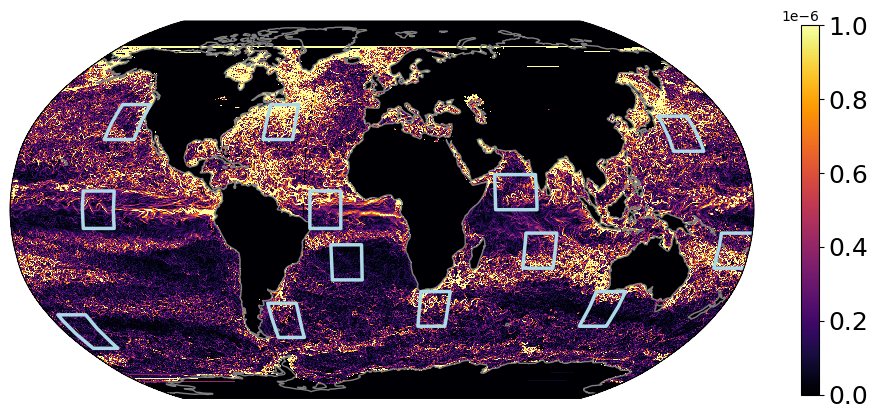

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
from shapely.geometry.polygon import LinearRing
import cartopy.feature as cfeature



PATH_LIST = glob.glob(BASE+'*_smooth/preprcossed_data/')

subplot_kws=dict(projection=ccrs.Robinson(),facecolor='black')#, set_extent([-180, 180, -70, 70]))

plt.figure(figsize=[12,8])


p = grad_B_surf_plot.fillna(0).plot(x='XC', y='YC',
                  vmin=0, vmax=1e-6,
                  cmap='inferno',
                  subplot_kws=subplot_kws,
                  transform=ccrs.PlateCarree(),
                  add_labels=False,
                  add_colorbar=False)

p.axes.coastlines(color='gray')
p.axes.stock_img()

for i_box in np.arange(len(lat_max)):
    lons = [lon_min[i_box], lon_min[i_box], lon_max[i_box], lon_max[i_box]]
    lats = [lat_min[i_box], lat_max[i_box], lat_max[i_box], lat_min[i_box]]
    ring = LinearRing(list(zip(lons, lats)))
    p.axes.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='lightblue', linewidth=2.5)
    
# add separate colorbar
cb = plt.colorbar(p, shrink=0.6)
cb.ax.tick_params(labelsize=18)



# background
#url = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'
#p.axes.add_wmts(url, 'BlueMarble_NextGeneration')

In [8]:
lat_min

array([  0., -55., -60.,  10.,  -8.,  30., -30., -50., -55., -25.])

In [9]:
lat_max

array([  9., -49., -55.,  19.,   1.,  38., -22., -44., -49., -16.])

In [10]:
lon_min

array([  55.,  -57., -175., -179.,  -29.,  -57.,  -25.,  -33., -125.,
         71.])

In [11]:
lon_max

array([  65.,  -47., -165., -169.,  -19.,  -47.,  -15.,  -23., -115.,
         81.])

In [ ]:
# create global plot of sst
# draw boxes on top